<a href="https://colab.research.google.com/github/libra3910/diveintocode-ml/blob/master/sprint_deep_learning_deep_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sprint 深層学習スクラッチ ディープニューラルネットワーク

In [ ]:
import numpy as np

In [ ]:
# Utilityクラス
# GetMiniBatch
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        
        return self._stop
    
    def __getitem__(self,item):
        
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        
        return self._X[p0:p1], self._y[p0:p1]   
    
    def __iter__(self):
        
        self._counter = 0
        
        return self
    
    def __next__(self):
        
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        
        return self._X[p0:p1], self._y[p0:p1]

In [ ]:
# Initializerクラス
# SimpleInitializer 【問題2】初期化方法のクラス化
class SimpleInitializer:
    
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# Xavier
class Xavier:
    """
    初期値を正規分布化するため、前層のノード数の根で除算する。
    活性化関数がシグモイド関数やハイパボリックタンジェント関数の場合に適用。
    
    """
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) * (1 / np.sqrt(n_nodes1))
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# He
class He:
    """
    （2×前層のノード数の根）で除算する。
    活性化関数がReLU関数の場合に適用。
    
    """
    def __init__(self, sigma, seed=0):
        
        self.sigma = sigma
        self.seed = seed
        np.random.seed(self.seed)
        
    def W(self, n_nodes1, n_nodes2):
        
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2) * (2 / np.sqrt(n_nodes1))
        
        return W
    
    def B(self, n_nodes2):
        
        B = self.sigma * np.random.randn(n_nodes2)
        
        return B

In [ ]:
# Optimizerクラス
# SGD
class SGD:

    def __init__(self, lr):
        
        self.lr = lr
        
    def update(self, layer):

        layer.W -= self.lr * np.dot(layer.X.T, layer.dA)
        layer.B -= self.lr * np.sum(layer.dA, axis=0)

In [ ]:
# AdaGrad
class AdaGrad:

    def __init__(self, lr):
        
        self.lr = lr
        self.HiW = 0
        self.HiB = 0
        
    def update(self, layer):
        
        self.HiW += layer.dAW ** 2
        self.HiB += layer.dAB ** 2
        
        layer.W -= self.lr * (1 / (np.sqrt(self.HiW) + 1e-7)) * layer.dAW
        layer.B -= self.lr * (1 / (np.sqrt(self.HiB) + 1e-7)) * layer.dAB
        
        return
        

In [ ]:
# Layerクラス
# FC
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):

        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer

        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する

        self.W = self.initializer.W(n_nodes1, n_nodes2)
        self.B = self.initializer.B(n_nodes2)
        self.X = None
        self.dA = None
        
    def forward(self, X):

        self.X = X
        A = np.dot(self.X, self.W) + self.B
        return A
    
    def backward(self, dA):

        self.dA = dA

        self.dAW = np.dot(self.X.T, self.dA)
        self.dAB = np.sum(self.dA, axis=0)
        
        dz = np.dot(dA, self.W.T)
        
        self = self.optimizer.update(self)

        return dz


In [ ]:
# ReLU
class ReLU:

    def __init__(self):

        self.A = None
    
    def forward(self, X):
  
        self.A = np.copy(X)
        
        return np.maximum(0, X)
        
    def backward(self, dA):

        return np.where(self.A > 0, dA, 0)

In [ ]:
# Tanh
class Tanh:

    def __init__(self):

        pass

    def forward(self, X):

        self.Z = (np.exp(X) - np.exp(-X)) / (np.exp(X) + np.exp(-X))
        return self.Z
        
    def backward(self, dA):
        
        dA2 = dA * (1 - self.Z**2)
        
        return dA2

In [ ]:
# Softmax
class Softmax:
    
    def __init__(self):
        
        pass
    
    def forward(self, X):
        
        dz = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        return dz
    
    def backward(self, Z3, y):

        y_one_hot = (y.reshape(-1,1)==np.arange(10))
        dza = (Z3 - y) / y.shape[0]
        #【問題3】交差エントロピー誤差の実装
        L = np.sum(np.mean(-(y_one_hot * Z3), axis=0))
        C = np.sum(np.array(dza).argmax(axis=1) == y)
        
        return dza, L, C

In [ ]:
# Calculates log(sum(exp(x)))
class logsumexp:
    
    def __init__(self):

        pass

    def forward(self, X):
        
        xmax = X.max(axis=1, keepdims=True)
        self.Z = np.log(np.exp(X - xmax).sum(axis=1, keepdims=True)) + xmax
        
        return self.Z

    def backward(self, Z3, log_Z3, y):

        y_one_hot = (y.reshape(-1,1)==np.arange(10))
        dza = (Z3 - y_one_hot) / y_one_hot.shape[0]

        L = np.sum(np.mean(-(y_one_hot * log_Z3), axis=0))
        C = np.sum(Z3.argmax(axis=1) == y)
        
        return dza, L, C

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Tranerクラス
class ScratchDeepNeuralNetrowkClassifier():
    """
    Trainerクラスの定義
    
    """
    # self.sigma : ガウス分布の標準偏差
    # self.lr : 学習率
    # self.n_nodes1 : 1層目のノード数
    # self.n_nodes2 : 2層目のノード数
    # self.n_output : 出力層のノード数
    
    batch_size = 20
    sigma = 0.01
    n_features = 784
    n_nodes1 = 400
    n_nodes2 = 200
    n_output = 10
    lr = 0.01

    def __init__(self, seed=0, verbose = True, verbose2 = False):
        
        self.seed = 0
        self.verbose = verbose
        self.verbose2 = verbose2

    def fit(self, X, y, X_val=None, y_val=None, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD"):    

        # 初期化関数
        if pinit == "Initializer":
            initializer = SimpleInitializer(self.sigma, self.seed)
        elif pinit == "Xavier":
            initializer = Xavier(self.sigma, self.seed)
        elif pinit == "He":
            initializer = He(self.sigma, self.seed)
        
        # 最適化関数
        if popt == "SGD":
            optimizer = SGD(self.lr)
        elif popt == "AdaGrad":
            optimizer1 = AdaGrad(self.lr) 
            optimizer2 = AdaGrad(self.lr) 
            optimizer3 = AdaGrad(self.lr) 
        
        # 活性化関数1
        if pact1 == "Tanh":
            self.activation1 = Tanh()
            self.activation2 = Tanh()
        if pact1 == "ReLU":
            self.activation1 = ReLU()
            self.activation2 = ReLU()

        # 活性化関数2
        if pact2 == "logsumexp":
            self.activation3 = logsumexp()
        elif pact2 == "Softmax":
            self.activation3 = Softmax()
        
        # 学習用関数初期化
        if popt == "SGD":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer) # W1: (784, 400)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer) # W2: (400, 200) 
            self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer) # W3: (200, 10)
        elif popt == "AdaGrad":
            self.FC1 = FC(self.n_features, self.n_nodes1, initializer, optimizer1) # W1: (784, 400)
            self.FC2 = FC(self.n_nodes1, self.n_nodes2, initializer, optimizer2) # W2: (400, 200) 
            self.FC3 = FC(self.n_nodes2, self.n_output, initializer, optimizer3) # W3: (200, 10)            
        
        epoch = 20
        n_step_iteration_report = 500
        plot_data = []
        
        # Utility(epochごとに、全データ分ミニバッチを取得)
        for i in range(epoch):

            sum_of_loss = 0
            get_mini_batch = GetMiniBatch(X, y, batch_size = self.batch_size)
            for j, (mini_X_train, mini_y_train) in enumerate(get_mini_batch):
                
                # 学習用Forward Propergation
                A1 = self.FC1.forward(mini_X_train)
                Z1 = self.activation1.forward(A1)
                A2 = self.FC2.forward(Z1)
                Z2 = self.activation2.forward(A2)
                A3 = self.FC3.forward(Z2)
                log_Z3 = A3 - self.activation3.forward(A3)
                Z3 = np.exp(log_Z3)
                
                # 学習用Back Propergation
                dA3,L,C = self.activation3.backward(Z3, log_Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない
                
                # ログ出力
                sum_of_loss += L
                if self.verbose and (j + 1) % n_step_iteration_report == 0:
                    train_loss = sum_of_loss / n_step_iteration_report

                    # 検証用Forward Propergation、損失、Accuracy
                    A1 = self.FC1.forward(X_val)
                    Z1 = self.activation1.forward(A1)
                    A2 = self.FC2.forward(Z1)
                    Z2 = self.activation2.forward(A2)
                    A3 = self.FC3.forward(Z2)
                    log_Z3 = A3 - self.activation3.forward(A3)
                    Z3 = np.exp(log_Z3)

                    dA3,val_loss,val_accuracy = self.activation3.backward(Z3, log_Z3, y_val)
                    
                    print(f'epoch: {i+1}, iteration: {j+1}, train_loss: {train_loss:.3}, val_loss: {val_loss:.3}, accuracty: {val_accuracy / len(y_val):.3}')
                    sum_of_loss = 0

                    iters_per_epoch = len(X_train) / self.batch_size
                    print("iters_per_epoch={}".format(iters_per_epoch))
                    plot_data.append((i + (j + 1) / iters_per_epoch, train_loss, val_loss))
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                pass
                
                if self.verbose2:
                    print("epoch={}".format(i))
                    print("forward propergation")                    
                    print(" A1={}".format(A1))
                    print(" Z1={}".format(Z1))
                    print(" A2={}".format(A2))
                    print(" Z2={}".format(Z2))
                    print(" A3={}".format(A3))
                    print(" Z3={}".format(Z3))
                    print("back propergation")
                    print("dA3={}".format(dA3))                    
                    print("dZ2={}".format(dZ2))
                    print("dA2={}".format(dA2))
                    print("dZ1={}".format(dZ1))
                    print("dA1={}".format(dA1))
                    print("dA0={}".format(dA0)) 
                    
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            epochs, train_loss, val_loss = zip(*plot_data)
            plt.plot(epochs, train_loss, color='r', label='train_loss')
            plt.plot(epochs, val_loss, color='b', label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.show()

    def predict(self, X):

        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        log_Z3 = A3 - self.activation3.forward(A3)
        y_pred = log_Z3.argmax(axis=1)
        
        return y_pred

In [ ]:
# データセットをダウンロードするコード
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [ ]:
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [ ]:
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [ ]:
y_train_one_hot = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
y_test_one_hot = (y_train.reshape(-1,1) == np.arange(10)).astype(np.float64)
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(60000,)
(60000, 10)
float64


In [ ]:
def split_data(X, permutation, val_size_rate=0.2):
    X = X[permutation]
    val_size = int(len(X) * val_size_rate)
    val = X[:val_size]
    train = X[val_size:]
    return train, val

permutation = np.random.permutation(np.arange(len(X_train)))
X_train, X_val = split_data(X_train, permutation)
y_train, y_val = split_data(y_train, permutation)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(48000, 784)
(48000,)
(12000, 784)
(12000,)


epoch: 1, iteration: 500, train_loss: 2.29, val_loss: 2.28, accuracty: 0.359
iters_per_epoch=2400.0
epoch: 1, iteration: 1000, train_loss: 2.23, val_loss: 2.08, accuracty: 0.354
iters_per_epoch=2400.0
epoch: 1, iteration: 1500, train_loss: 1.66, val_loss: 1.27, accuracty: 0.595
iters_per_epoch=2400.0
epoch: 1, iteration: 2000, train_loss: 1.01, val_loss: 0.827, accuracty: 0.761
iters_per_epoch=2400.0
epoch: 2, iteration: 500, train_loss: 0.626, val_loss: 0.58, accuracty: 0.833
iters_per_epoch=2400.0
epoch: 2, iteration: 1000, train_loss: 0.546, val_loss: 0.513, accuracty: 0.855
iters_per_epoch=2400.0
epoch: 2, iteration: 1500, train_loss: 0.488, val_loss: 0.466, accuracty: 0.867
iters_per_epoch=2400.0
epoch: 2, iteration: 2000, train_loss: 0.451, val_loss: 0.433, accuracty: 0.879
iters_per_epoch=2400.0
epoch: 3, iteration: 500, train_loss: 0.408, val_loss: 0.396, accuracty: 0.889
iters_per_epoch=2400.0
epoch: 3, iteration: 1000, train_loss: 0.383, val_loss: 0.381, accuracty: 0.893
iter

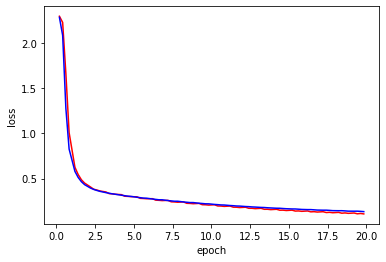

In [ ]:
dnnc = ScratchDeepNeuralNetrowkClassifier()
dnnc.fit(X_train, y_train, X_val, y_val, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="SGD")

epoch: 1, iteration: 500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 1, iteration: 1000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 1, iteration: 1500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 1, iteration: 2000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 1000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 1500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 2000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 3, iteration: 500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 3, iteration: 1000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 3, ite

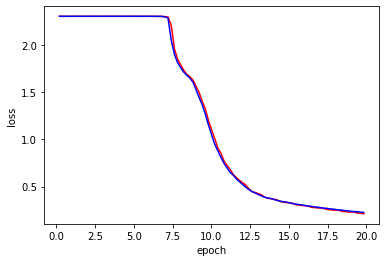

In [ ]:
dnnc = ScratchDeepNeuralNetrowkClassifier()
dnnc.fit(X_train, y_train, X_val, y_val, pinit="Xavier", pact1="Tanh", pact2="logsumexp", popt="SGD")

epoch: 1, iteration: 500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 1, iteration: 1000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 1, iteration: 1500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 1, iteration: 2000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 1000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 1500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 2, iteration: 2000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 3, iteration: 500, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 3, iteration: 1000, train_loss: 2.3, val_loss: 2.3, accuracty: 0.108
iters_per_epoch=2400.0
epoch: 3, ite

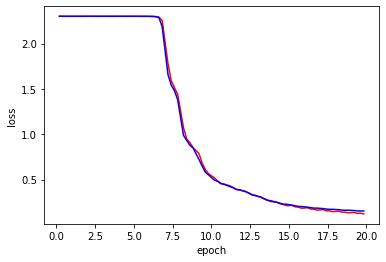

In [ ]:
dnnc = ScratchDeepNeuralNetrowkClassifier()
dnnc.fit(X_train, y_train, X_val, y_val, pinit="He", pact1="ReLU", pact2="logsumexp", popt="SGD")

epoch: 1, iteration: 500, train_loss: 0.464, val_loss: 0.286, accuracty: 0.917
iters_per_epoch=2400.0
epoch: 1, iteration: 1000, train_loss: 0.261, val_loss: 0.236, accuracty: 0.931
iters_per_epoch=2400.0
epoch: 1, iteration: 1500, train_loss: 0.23, val_loss: 0.214, accuracty: 0.938
iters_per_epoch=2400.0
epoch: 1, iteration: 2000, train_loss: 0.207, val_loss: 0.195, accuracty: 0.944
iters_per_epoch=2400.0
epoch: 2, iteration: 500, train_loss: 0.17, val_loss: 0.175, accuracty: 0.947
iters_per_epoch=2400.0
epoch: 2, iteration: 1000, train_loss: 0.157, val_loss: 0.167, accuracty: 0.952
iters_per_epoch=2400.0
epoch: 2, iteration: 1500, train_loss: 0.155, val_loss: 0.159, accuracty: 0.954
iters_per_epoch=2400.0
epoch: 2, iteration: 2000, train_loss: 0.145, val_loss: 0.151, accuracty: 0.955
iters_per_epoch=2400.0
epoch: 3, iteration: 500, train_loss: 0.13, val_loss: 0.145, accuracty: 0.956
iters_per_epoch=2400.0
epoch: 3, iteration: 1000, train_loss: 0.122, val_loss: 0.142, accuracty: 0.959

epoch: 20, iteration: 2000, train_loss: 0.0173, val_loss: 0.0769, accuracty: 0.977
iters_per_epoch=2400.0


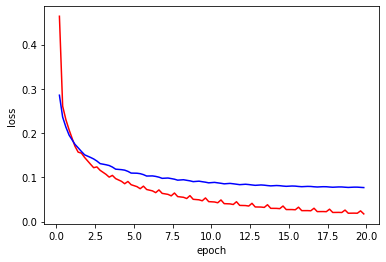

In [ ]:
dnnc = ScratchDeepNeuralNetrowkClassifier()
dnnc.fit(X_train, y_train, X_val, y_val, pinit="Initializer", pact1="Tanh", pact2="logsumexp", popt="AdaGrad")